In [1]:
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle as pkl

In [2]:
def imregionalmax(image, footprint):
    """Find the regional max of an ND image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - footprint: a boolean ndarray specifying which neighboring pixels should be considered
                 for thresholding, see scipy.ndimage.generate_binary_structure.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = ndimage.grey_dilation(image, footprint=footprint, mode='reflect')
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = ndimage.grey_erosion(image, footprint=footprint, mode='reflect')
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)
def imregionalmin(image, footprint):
    """Find the regional min of an ND image. An approximation of MATLAB's
    imregionalmin function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - footprint: a boolean ndarray specifying which neighboring pixels should be considered
                 for thresholding, see scipy.ndimage.generate_binary_structure.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # erode the image so that high values are replaced by local min
    local_min = ndimage.grey_erosion(image, footprint=footprint, mode='reflect')
    # non-local min pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local min, so the values will decrease. remove them.
    # so the result is either local min or constant neighborhood.
    min_mask = image <= local_min
    # dialate the image so that small values are replaced by local max
    local_max = ndimage.grey_dilation(image, footprint=footprint, mode='reflect')
    # only local max pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # max and become larger. We only take non-local max, non-constant values.
    max_mask = image < local_max
    # boolean logic hack
    #   (local min || constant) && (!local max && !constant)
    # = local min && !local max && !constant
    # = local min && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [3]:
def localize_kps(imgs, x, y, s):
    dx_kernal = np.array([[0,1/2,0],[0,0,0],[0,-1/2,0]])
    dy_kernal = np.array([[0,0,0],[1/2,0,-1/2],[0,0,0]])
    dxx_kernal = np.array([[0,0,0],[1,-2,1],[0,0,0]])
    dyy_kernal = np.array([[0,1,0],[0,-2,0],[0,1,0]])
    dxy_kernal = np.array([[-1,0,1],[0,0,0],[1,0,-1]])
                          
    dx_img = cv2.filter2D(imgs[s], -1, dx_kernal)
    dy_img = cv2.filter2D(imgs[s], -1, dy_kernal)
    dxx_img = cv2.filter2D(imgs[s], -1, dxx_kernal)
    dxy_img = cv2.filter2D(imgs[s], -1, dxy_kernal)
    dyy_img = cv2.filter2D(imgs[s], -1, dyy_kernal)
    
    dx_img_prev = cv2.filter2D(imgs[s-1], -1, dx_kernal)
    dx_img_next = cv2.filter2D(imgs[s+1], -1, dx_kernal)
    
    dy_img_prev = cv2.filter2D(imgs[s-1], -1, dy_kernal)
    dy_img_next = cv2.filter2D(imgs[s+1], -1, dy_kernal)
    
    
    dx = dx_img[y, x]
    dy = dy_img[y, x]
    ds = imgs[s+1][y, x] - imgs[s-1][y,x]
    dxx = dxx_img[y, x]
    dxy = dxy_img[y, x]
    dyy = dyy_img[y, x]
    dxs = (dx_img_prev[y, x] - dx_img_next[y, x])/2
    dys = (dy_img_prev[y, x] - dy_img_next[y, x])/2
    dss = imgs[s+1][y,x] - 2*imgs[s][y,x] + imgs[s-1][y,x]
    
    J = np.array([dx, dy, ds]) 
    HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
    
    
    offset = -np.linalg.pinv(HD).dot(J)
    return offset, J, HD[:2,:2], x, y, s

def generate_gaussian_kernel(sigma, w):
    k = np.zeros((w,w))
    x = int(w/2)
    k[x][x] = 1.0
    g_kernel = cv2.GaussianBlur(k, (w,w), sigma)
    return g_kernel


In [4]:
def get_orientation(D, kp, s):
    dog_img = D[s]
    sigma = 1.5*s
    [ky, kx] = kp
    w = int(2*np.ceil(sigma)+1)
    kernel = generate_gaussian_kernel(s, w)
    
    dx_kernal = np.array([[0,1/2,0],[0,0,0],[0,-1/2,0]])
    dy_kernal = np.array([[0,0,0],[1/2,0,-1/2],[0,0,0]])
    dx_img = cv2.filter2D(dog_img, -1, dx_kernal)+1e-15
    dy_img = cv2.filter2D(dog_img, -1, dy_kernal)+1e-15
    
    angle_img = np.degrees(np.arctan(dy_img/dx_img))%360
    
    try:
        y1 = int(ky-w/2)
        y2 = int(ky+w/2)
        x1 = int(kx-w/2)
        x2 = int(kx+w/2)
        patch = angle_img[y1:y2, x1:x2]
        hist = np.zeros(36, dtype = np.float32)
        for y in range(w):
            for x in range(w):
                hist[int(patch[y,x]//10)] += kernel[y,x] * patch[y,x]

    except:
        return np.resize(np.array([]),(0,3))
    
    
    
    
            
    argsorted_hist = np.argsort(hist)
    if 0.8*hist[argsorted_hist[-2]]>=hist[argsorted_hist[-1]]:
        return np.array([[ky, kx, argsorted_hist[-1]*10],[ky, kx, argsorted_hist[-1]*10]])
    else:
        return np.array([[ky, kx, argsorted_hist[-1]*10]])
    
def get_descriptor(new_kp, D_img):
    [y, x, theta] = new_kp
    x = int(x)
    y = int(y)
    try:
        kp_sub_area = D_img[y-13:y+13,x-13:x+13]
        plt.imshow(kp_sub_area,cmap='gray')
        M = cv2.getRotationMatrix2D((13,13), theta, 1.0)
        rotated_sub_area = cv2.warpAffine(kp_sub_area, M, np.shape(kp_sub_area))

        dx_kernal = np.array([[0,1/2,0],[0,0,0],[0,-1/2,0]])
        dy_kernal = np.array([[0,0,0],[1/2,0,-1/2],[0,0,0]])
        dx_img = cv2.filter2D(rotated_sub_area, -1, dx_kernal)+1e-15
        dy_img = cv2.filter2D(rotated_sub_area, -1, dy_kernal)+1e-15

        angle_img = np.degrees(np.arctan(dy_img/dx_img))%360

        angle_subarea = angle_img[13-8:13+8, 13-8:13+8]
        descriptor = np.array(subarea_to_descriptor(angle_subarea))
        descriptor = np.ndarray.flatten(descriptor)

        return descriptor
    except Exception as e:
        return np.reshape(np.array([]),(0,128))
    
    
def subarea_to_descriptor(sub_area):
    sub_regions = [sub_area[y:y+4, x:x+4] for x in range(0,16,4) for y in range(0,16,4)]
    
    descriptor = []
    for sub_region in sub_regions:
        descriptor.append(sub_region_to_hist(sub_region))
    return descriptor
        
        
def sub_region_to_hist(sub_region):
    kernel = np.array([[1,3,3,1],[3,9,9,3],[3,9,9,3],[1,3,3,1]])/64
    hist = np.zeros(8, dtype = np.float32)
    for y in range(4):
        for x in range(4):
            hist[int(sub_region[y,x]//45)] += sub_region[y,x]*kernel[y,x]
            
    hist /= np.linalg.norm(hist)
    hist[hist>0.2] = 0.2
    hist /= np.linalg.norm(hist)
    
    return hist


def dof_to_candidate_kps(dof, s):
    c_kps = []
    (d_h, d_w) = np.shape(dof[s])
    mask = np.array([[True, True, True],[True, False, True],[True, True, True]])
    for m in range(1, d_h-1):
        for n in range(1, d_w-1):
            max_val1 = np.max(dof[s][m-1:m+2,n-1:n+2][mask])
            max_val2 = np.max(dof[s-1][m-1:m+2,n-1:n+2])
            max_val3 = np.max(dof[s+1][m-1:m+2,n-1:n+2])

            min_val1 = np.min(dof[s][m-1:m+2,n-1:n+2][mask])
            min_val2 = np.min(dof[s-1][m-1:m+2,n-1:n+2])
            min_val3 = np.min(dof[s+1][m-1:m+2,n-1:n+2])
            if dof[s][m][n] > max(max_val1, max_val2, max_val3) or dof[s][m][n] < min(min_val1, min_val2, min_val3):
                c_kps.append([m, n])


    c = np.array(c_kps)
    return(c)

In [5]:
def dof_to_descriptors(dof):
    dof_max1 = imregionalmax(np.stack((dof[0],dof[1],dof[2])), ndimage.generate_binary_structure(3,3))[1]
    dof_min1 = imregionalmin(np.stack((dof[0],dof[1],dof[2])), ndimage.generate_binary_structure(3,3))[1]
        
    dof_max2 = imregionalmax(np.stack((dof[1],dof[2],dof[3])), ndimage.generate_binary_structure(3,3))[1]
    dof_min2 = imregionalmin(np.stack((dof[1],dof[2],dof[3])), ndimage.generate_binary_structure(3,3))[1]
    
    dof_max3 = imregionalmax(np.stack((dof[2],dof[3],dof[4])), ndimage.generate_binary_structure(3,3))[1]
    dof_min3 = imregionalmin(np.stack((dof[2],dof[3],dof[4])), ndimage.generate_binary_structure(3,3))[1]
    
    candidate_kps1 = np.vstack((np.array(np.where(dof_max1)).T, np.array(np.where(dof_min1)).T))

    candidate_kps2 = np.vstack((np.array(np.where(dof_max2)).T, np.array(np.where(dof_min2)).T))

    candidate_kps3 = np.vstack((np.array(np.where(dof_max3)).T, np.array(np.where(dof_min3)).T))
    
    filtered_kps1 = []
    for kp in candidate_kps1:
        [y, x] = kp
        offset, J, HD, x, y, s = localize_kps(dof, x, y, 1)
        res = dof[1][y,x] + 0.5*np.dot(J.T,offset)
        if abs(res) >= 0.03:
            w, v = np.linalg.eig(HD)
            w += 10e-15
            r = w[1]/w[0]
            R = (r+1)**2/r
            if R >= (10+1)**2/10:

                filtered_kps1.append(kp)
    filtered_kps1 = np.array(filtered_kps1)
    print('len of filtered_kps1:{}'.format(len(filtered_kps1)))
    
    filtered_kps2 = []

    for kp in candidate_kps2:
        [y, x] = kp
        offset, J, HD, x, y, s = localize_kps(dof, x, y, 2)
        res = dof[2][y,x] + 0.5*np.dot(J.T,offset)
        if abs(res) >= 0.03:
            w, v = np.linalg.eig(HD)
            w += 10e-15
            r = w[1]/w[0]
            R = (r+1)**2/r
            if R >= (10+1)**2/10:

                filtered_kps2.append(kp)
    filtered_kps2 = np.array(filtered_kps2)
    print('len of filtered_kps2:{}'.format(len(filtered_kps2)))
    
    filtered_kps3 = []
    for kp in candidate_kps3:
        [y, x] = kp
        offset, J, HD, x, y, s = localize_kps(dof, x, y, 3)
        res = dof[3][y,x] + 0.5*np.dot(J.T,offset)
        if abs(res) >= 0.03:
            w, v = np.linalg.eig(HD)
            w += 10e-15
            r = w[1]/w[0]
            R = (r+1)**2/r
            if R >= (10+1)**2/10:
                filtered_kps3.append(kp)
    filtered_kps3 = np.array(filtered_kps3)
    print('len of filtered_kps3:{}'.format(len(filtered_kps3)))
 
    try:
        kps_and_orientation1 = np.vstack(tuple([get_orientation(dof, kp, 1) for kp in filtered_kps1]))
        des1 = np.vstack(tuple([get_descriptor(kp, dof[1]) for kp in kps_and_orientation1]))

    except:
        des1 = np.reshape(np.array([]),(0,128))
    
    try:
        kps_and_orientation2 = np.vstack(tuple([get_orientation(dof, kp, 2) for kp in filtered_kps2]))
        des2 = np.vstack(tuple([get_descriptor(kp, dof[2]) for kp in kps_and_orientation2]))

    except:
        des2 = np.reshape(np.array([]),(0,128))
        
    try:
        kps_and_orientation3 = np.vstack(tuple([get_orientation(dof, kp, 3) for kp in filtered_kps3]))
        des3 = np.vstack(tuple([get_descriptor(kp, dof[3]) for kp in kps_and_orientation3]))

    except:
        des3 = np.reshape(np.array([]),(0,128))
    
    
    
    
    print(np.vstack((des1,des2,des3)))
    print(np.shape(np.vstack((des1,des2,des3))))
    print('finished')
    
    return(np.vstack((des1,des2,des3)))

In [6]:
def img_to_descriptors(test_img):
    
    # creating feature space
    (oct1_h, oct1_w) = np.shape(test_img)
    octave1 = [cv2.GaussianBlur(test_img, (5,5), 2**(i/5)).astype(np.float64) for i in range(6)]
    dof1 = [abs(octave1[i+1] - octave1[i])/255 for i in range(5)]

    test_img2 = cv2.resize(test_img,((int(np.shape(test_img)[1]/2), int(np.shape(test_img)[0]/2))))
    octave2 = [cv2.GaussianBlur(test_img2, (5,5), 2**(i/5)).astype(np.float64) for i in range(6)]
    dof2 = [abs(octave2[i+1] - octave2[i])/255 for i in range(5)]

    test_img3 = cv2.resize(test_img,((int(np.shape(test_img2)[1]/2), int(np.shape(test_img2)[0]/2))))
    octave3 = [cv2.GaussianBlur(test_img3, (5,5), 2**(i/5)).astype(np.float64) for i in range(6)]
    dof3 = [abs(octave3[i+1] - octave3[i])/255 for i in range(5)]

    test_img4 = cv2.resize(test_img,((int(np.shape(test_img3)[1]/2), int(np.shape(test_img3)[0]/2))))
    octave4 = [cv2.GaussianBlur(test_img4, (5,5), 2**(i/5)).astype(np.float64) for i in range(6)]
    dof4 = [abs(octave4[i+1] - octave4[i])/255 for i in range(5)]

    test_img5 = cv2.resize(test_img,((int(np.shape(test_img4)[1]/2), int(np.shape(test_img4)[0]/2))))
    octave5 = [cv2.GaussianBlur(test_img5, (5,5), 2**(i/5)).astype(np.float64) for i in range(6)]
    dof5 = [abs(octave5[i+1] - octave5[i])/255 for i in range(5)]
    
    print('initiating')
    
    
    dof2_descriptors = dof_to_descriptors(dof2)
    
    
    return(dof2_descriptors)

In [8]:
from os import listdir
def generate_pkl_files(obj, N):
    for file_name in listdir(obj)[0:N]:
        img_name = file_name.split('.')[0]
        
        img_path = obj+'/' + img_name+'.jpg'
        pkl_path = obj+'_descriptors/'+img_name+'_descriptor.pkl'
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        try:
            f = open(pkl_path, 'wb')
            pkl.dump(img_to_descriptors(img), f)
            f.close()
            print('successfully stored: ' + img_name)
        except Exception as e:
            print('error: ' + str(e))

In [9]:
def generate_test_pkl_files(obj):
    for file_name in listdir(obj+'_test'):
        img_name = file_name.split('.')[0]
        img_path = obj+'_test/'+file_name
        pkl_path = obj+'_test_descriptors/'+img_name+'_descriptors.pkl'
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        try:
            f = open(pkl_path, 'wb')
            pkl.dump(img_to_descriptors(img), f)
            f.close()
            print('successfully stored: ' + img_name)
        except Exception as e:
            print('error: ' + str(e))
        
generate_test_pkl_files('airplanes')

In [10]:
generate_pkl_files('Leopards', 50)

## Genereate bag of visual words

In [11]:
all_descriptors = []
for des_name in listdir('Leopards_descriptors'):
    pkl_name = 'Leopards_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    all_descriptors.append(des)
    
for des_name in listdir('dolphin_descriptors'):
    pkl_name = 'dolphin_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    all_descriptors.append(des)
    
for des_name in listdir('airplanes_descriptors'):
    pkl_name = 'airplanes_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    all_descriptors.append(des)
all_descriptors = np.vstack(tuple(all_descriptors))
print(np.shape(all_descriptors))

(27635, 128)


In [12]:
from sklearn.cluster import KMeans
n_clusters = 50
kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(all_descriptors)


In [13]:
kmeans.cluster_centers_
kmeans.labels_

array([26, 29, 26, ..., 42, 16, 12])

In [14]:
def descriptors_to_hist(descriptors,k_mean_model):
    des = descriptors[0:20]
    hist = np.zeros(n_clusters, dtype = np.float32)
    for i in k_mean_model.predict(des):
        hist[i] += 1
    return hist


In [15]:
leopard_descriptors = []

for des_name in listdir('Leopards_descriptors'):
    pkl_name = 'Leopards_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    leopard_descriptors.append(des)
leopard_hist = np.vstack(tuple([descriptors_to_hist(d, kmeans) for d in leopard_descriptors]))
leopard_label = np.ones(50)
print(leopard_hist)
print(leopard_label)
print(np.shape(leopard_hist))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
(50, 50)


In [16]:
dolphin_descriptors = []

for des_name in listdir('dolphin_descriptors'):
    pkl_name = 'dolphin_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    dolphin_descriptors.append(des)
dolphin_hist = np.vstack(tuple([descriptors_to_hist(d, kmeans) for d in dolphin_descriptors]))
dolphin_label = np.zeros(50)

In [17]:
airplanes_descriptors = []

for des_name in listdir('airplanes_descriptors'):
    pkl_name = 'airplanes_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    airplanes_descriptors.append(des)
airplanes_hist = np.vstack(tuple([descriptors_to_hist(d, kmeans) for d in airplanes_descriptors]))
airplanes_label = np.zeros(50)
print(len(airplanes_hist))

50


## Leopard vs All

In [32]:
X, Y = np.vstack((leopard_hist, dolphin_hist, airplanes_hist)), np.hstack((leopard_label, dolphin_label,np.zeros(50)))
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X,Y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
leopard_test_descriptors = []

for des_name in listdir('Leopards_test_descriptors'):
    pkl_name = 'Leopards_test_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    leopard_test_descriptors.append(des)
leopard_test_hist = np.vstack(tuple([descriptors_to_hist(d, kmeans) for d in leopard_test_descriptors]))
print(np.shape(leopard_test_hist))

(15, 50)


In [34]:
dolphin_test_descriptors = []

for des_name in listdir('dolphin_test_descriptors'):
    pkl_name = 'dolphin_test_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    dolphin_test_descriptors.append(des)
dolphin_test_hist = np.vstack(tuple([descriptors_to_hist(d, kmeans) for d in dolphin_test_descriptors]))

In [35]:
airplanes_test_descriptors = []

for des_name in listdir('airplanes_test_descriptors'):
    pkl_name = 'airplanes_test_descriptors/'+des_name
    f = open(pkl_name,'rb')
    des = pkl.load(f)
    f.close()
    airplanes_test_descriptors.append(des)
airplanes_test_hist = np.vstack(tuple([descriptors_to_hist(d, kmeans) for d in airplanes_test_descriptors]))

In [36]:
X_test = np.vstack((leopard_test_hist, dolphin_test_hist, airplanes_test_hist))
Y_test = np.hstack((np.ones(15),np.zeros(30)))
y_pred = clf.predict(X_test)
mismatch = len(y_pred[y_pred!=Y_test])
acc = (len(y_pred) - mismatch)/len(y_pred)
print('prediction')
print(y_pred)
print('actual')
print(Y_test)
print('number of mismatch')
print(mismatch)
print('accuarcy')
print(acc)


prediction
[1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
actual
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
number of mismatch
8
accuarcy
0.8222222222222222


## Airplanes VS all

In [39]:
X, Y = np.vstack((airplanes_hist, leopard_hist, dolphin_hist)), np.hstack((np.ones(50),np.zeros(100)))
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X,Y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
X_test = np.vstack((airplanes_test_hist, leopard_test_hist, dolphin_test_hist))
Y_test = np.hstack((np.ones(15),np.zeros(30)))
y_pred = clf.predict(X_test)
mismatch = len(y_pred[y_pred!=Y_test])
acc = (len(y_pred) - mismatch)/len(y_pred)
print('prediction')
print(y_pred)
print('actual')
print(Y_test)
print('number of mismatch')
print(mismatch)
print('accuarcy')
print(acc)

## Dolphins VS all

In [41]:
X, Y = np.vstack((dolphin_hist, leopard_hist, airplanes_hist)), np.hstack((np.ones(50),np.zeros(100)))
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X,Y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
X_test = np.vstack((dolphin_test_hist, leopard_test_hist, airplanes_test_hist))
Y_test = np.hstack((np.ones(15),np.zeros(30)))
y_pred = clf.predict(X_test)
mismatch = len(y_pred[y_pred!=Y_test])
acc = (len(y_pred) - mismatch)/len(y_pred)
print('prediction')
print(y_pred)
print('actual')
print(Y_test)
print('number of mismatch')
print(mismatch)
print('accuarcy')
print(acc)

prediction
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
actual
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
number of mismatch
15
accuarcy
0.6666666666666666


## Confusion matrix

Based on the result shown in the previous blocks, we can construct a confusion matrix as shown in the following block

$\begin{bmatrix}
A/P & Leopard & Airplane & Dolphin\\
Leopard& 37 & 5 & 3\\
Airplane & 3 & 38 & 4\\
Dolphin & 7 & 8 & 30
\end{bmatrix}$

## A visualization of histogram of bags

initiating
len of filtered_kps1:53
len of filtered_kps2:513
len of filtered_kps3:63


C:\Users\shiyu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
C:\Users\shiyu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


[[1.55182078e-01 4.31319028e-01 0.00000000e+00 ... 0.00000000e+00
  6.58815145e-01 6.58815145e-01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.51445627e-01 6.51445627e-01]
 [1.98123039e-13 5.77350259e-01 0.00000000e+00 ... 0.00000000e+00
  5.04136860e-01 6.10442758e-01]
 ...
 [4.96419147e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.02562606e-01 6.75026596e-01]
 [2.80419867e-02 1.20390542e-01 0.00000000e+00 ... 0.00000000e+00
  7.04833329e-01 7.04833329e-01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.77350259e-01 5.77350259e-01]]
(446, 128)
finished
sample_visbag


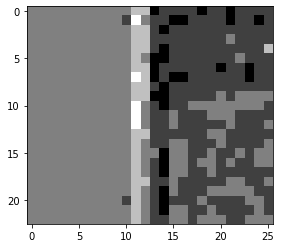

In [50]:
sample_img = cv2.imread('airplanes/image_0001.jpg', cv2.IMREAD_GRAYSCALE)
sample_des = img_to_descriptors(sample_img)
vis_hist = descriptors_to_hist(sample_des, kmeans)
print('sample_visbag')

displaying histogram for image 0001


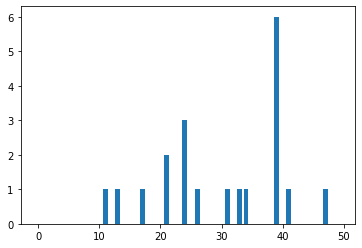

In [51]:
print('displaying histogram for image 0001')
plt.bar(range(50),vis_hist)
plt.show()